In [60]:
import numpy as np
import pandas as pd
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from soundfile import SoundFile
import pandas as pd
from IPython.display import Audio
from pathlib import Path

import matplotlib.pyplot as plt

from tqdm import tqdm

import joblib, json, re
import noisereduce as nr

In [61]:
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import torch.multiprocessing as mp
import warnings
from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm
from pytorch_lightning.loggers import WandbLogger
import gc

warnings.filterwarnings('ignore')

In [62]:
PATH = r'./kaggle/input/birdclef-2024/'

## Import Data

In [63]:
df = pd.read_csv(fr'{PATH}/train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [64]:
df['primary_label'].value_counts().unique()

array([500, 420, 405, 302, 278, 276, 275, 274, 273, 271, 268, 237, 235,
       231, 226, 224, 219, 217, 210, 201, 198, 189, 185, 173, 167, 163,
       155, 153, 150, 142, 141, 139, 137, 135, 127, 125, 124, 123, 122,
       115, 114, 113, 109, 107, 105, 104, 102, 101,  96,  92,  90,  89,
        86,  79,  77,  76,  75,  71,  70,  67,  63,  61,  60,  59,  58,
        57,  56,  53,  52,  51,  49,  47,  46,  45,  44,  42,  41,  40,
        39,  38,  37,  36,  35,  34,  33,  32,  31,  30,  29,  28,  27,
        26,  25,  24,  22,  21,  20,  19,  17,  16,  15,  14,  13,  12,
        10,   9,   8,   7,   6,   5])

In [65]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['primary_label'], random_state=42)

print(len(df_train['primary_label'].unique()), len(df_train['primary_label'].unique()))
print(len(df_train), len(df_test))

182 182
19567 4892


## Audio to Image

In [ ]:
class Config:
    audios_path = Path(fr"{PATH}/train_audio")
    sampling_rate = 32000
    duration = 15
    fmin = 20
    fmax = 16000
    # Output path
    train_path = Path(fr"{PATH}/train")
    test_path = Path(fr"{PATH}test")

Config.train_path.mkdir(exist_ok=True, parents=True)
Config.test_path.mkdir(exist_ok=True, parents=True)

In [67]:
def get_audio_info(filepath):
    with SoundFile(filepath) as f:
        sr = f.samplerate
        frames = f.frames
        duration = float(frames)/sr
    return {"frames": frames, "sr": sr, "duration": duration}

In [68]:
def add_path_df(df):
    
    df["path"] = [str(Config.audios_path/filename) for filename in df.filename]
    df = df.reset_index(drop=True)
    pool = joblib.Parallel(2)
    mapper = joblib.delayed(get_audio_info)
    tasks = [mapper(filepath) for filepath in df.path]
    df2 =  pd.DataFrame(pool(tqdm(tasks))).reset_index(drop=True)
    df = pd.concat([df,df2], axis=1).reset_index(drop=True)

    return df

In [69]:
# df_train = add_path_df(df_train)
# df_train.to_csv(fr"{PATH}/df_train.csv", index=False)

In [70]:
# df_test = add_path_df(df_test)
# df_test.to_csv(fr"{PATH}/df_test.csv", index=False)

In [71]:
def compute_melspec(y, sr, n_mels, fmin, fmax):
    melspec = lb.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax,
    )

    melspec = lb.power_to_db(melspec).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [72]:
class AudioToImage:
    def __init__(self, sr=Config.sampling_rate, n_mels=128, fmin=Config.fmin, fmax=Config.fmax, duration=Config.duration, step=None, res_type="kaiser_fast", resample=True, train = True):

        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax or self.sr//2

        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.step = step or self.audio_length
        
        self.res_type = res_type
        self.resample = resample

        self.train = train
    def audio_to_image(self, audio):
        melspec = compute_melspec(audio, self.sr, self.n_mels, self.fmin, self.fmax ) 
        image = mono_to_color(melspec)
#         compute_melspec(y, sr, n_mels, fmin, fmax)
        return image

    def __call__(self, row, save=True):

      y, orig_sr = lb.load(row.path)
      audio = nr.reduce_noise(y=y, sr=orig_sr)
        
      if self.resample and orig_sr != self.sr:
          audio = lb.resample(y = audio, orig_sr = orig_sr, target_sr = self.sr, res_type=self.res_type)
    
      audios = [audio[i:i+self.audio_length] for i in range(0, max(1, len(audio) - self.audio_length + 1), self.step)]
      audios[-1] = crop_or_pad(audios[-1] , length=self.audio_length)
      images = [self.audio_to_image(audio) for audio in audios]
      images = np.stack(images)
        
      if save:
        if self.train:
            path = Config.train_path/f"{row.filename}.npy"
        else:
            path = Config.test_path/f"{row.filename}.npy"
            
        path.parent.mkdir(exist_ok=True, parents=True)
        np.save(str(path), images)
      else:
        return  row.filename, images

In [73]:
tqdm.pandas()

In [74]:
def get_audios_as_images(df, train = True):
    pool = joblib.Parallel(2)
    
    converter = AudioToImage(step=int(Config.duration*0.666*Config.sampling_rate),train=train)
    mapper = joblib.delayed(converter)
    tasks = [mapper(row) for row in df.itertuples(False)]
    pool(tqdm(tasks))

In [75]:
# get_audios_as_images(df_train, train = True)
# get_audios_as_images(df_test, train = False)

## Training

In [76]:
class Config:
    use_aug = False
    num_classes = len(df_train.primary_label.unique())
    batch_size = 64
    epochs = 10
    PRECISION = 16    
    PATIENCE = 8    
    seed = 42
    model = "tf_efficientnet_b0_ns"
    pretrained = True            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.2   
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

    train_images = PATH+"/train/"
    valid_images = PATH + "/test/"
    train_path = PATH+"/df_train.csv"
    test_path = PATH+"/df_test.csv"
    
    
    SR = 32000
    DURATION = 10
    MAX_READ_SAMPLES = 5
    LR = 5e-4

In [77]:
pl.seed_everything(Config.seed, workers=True)

Seed set to 42


42

In [78]:
def config_to_dict(cfg):
    return dict((name, getattr(cfg, name)) for name in dir(cfg) if not name.startswith('__'))

In [79]:
df_train = pd.read_csv(Config.train_path)
df_test = pd.read_csv(Config.test_path)
df_train = pd.concat([df_train, pd.get_dummies(df_train['primary_label'])], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['primary_label'])], axis=1)

In [80]:
class BirdDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Config.SR, duration = Config.DURATION, augmentations = None, train = True):

        self.df = df
        self.sr = sr 
        self.train = train
        self.duration = duration
        self.augmentations = augmentations
        if train:
            self.img_dir = Config.train_images
        else:
            self.img_dir = Config.valid_images

    def __len__(self):
        return len(self.df)

    @staticmethod
    def normalize(image):
        image = image / 255.0
        #image = torch.stack([image, image, image])
        return image

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        impath = self.img_dir + f"{row.filename}.npy"

        image = np.load(str(impath))[:Config.MAX_READ_SAMPLES]
        
        ########## RANDOM SAMPLING ################
        if self.train:
            image = image[np.random.choice(len(image))]
        else:
            image = image[0]
            
        #####################################################################
        
        image = torch.tensor(image).float()

        if self.augmentations:
            image = self.augmentations(image.unsqueeze(0)).squeeze()
            
        image.size()
        
        image = torch.stack([image, image, image])

        image = self.normalize(image)


        return image, torch.tensor(row[16:]).float()

In [81]:
def get_fold_dls(df_train, df_test):

    ds_train = BirdDataset(
        df_train, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = True
    )
    ds_test = BirdDataset(
        df_test, 
        sr = Config.SR,
        duration = Config.DURATION,
        train = False
    )
    dl_train = DataLoader(ds_train, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    dl_test = DataLoader(ds_test, batch_size=Config.batch_size, num_workers = 2)
    return dl_train, dl_test, ds_train, ds_test

In [82]:
def show_batch(img_ds, num_items, num_rows, num_cols, predict_arr=None):
    fig = plt.figure(figsize=(12, 6))    
    img_index = np.random.randint(0, len(img_ds)-1, num_items)
    for index, img_index in enumerate(img_index):  # list first 9 images
        img, lb = img_ds[img_index]        
        ax = fig.add_subplot(num_rows, num_cols, index + 1, xticks=[], yticks=[])
        if isinstance(img, torch.Tensor):
            img = img.detach().numpy()
        if isinstance(img, np.ndarray):
            img = img.transpose(1, 2, 0)
            ax.imshow(img)        
            
        title = f"Spec"
        ax.set_title(title)  

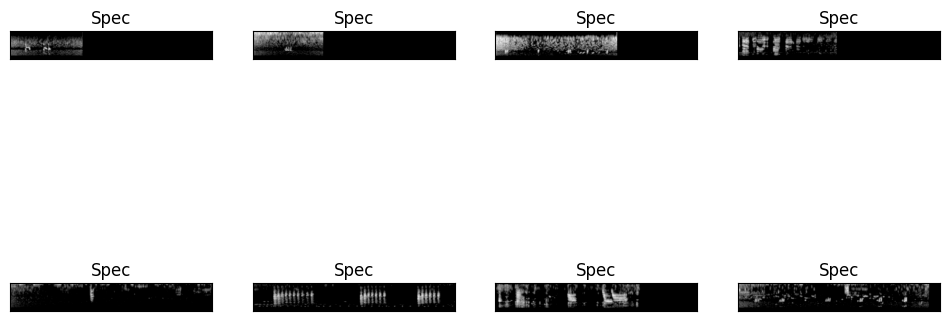

In [83]:
dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
show_batch(ds_test, 8, 2, 4)

In [84]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.weight_decay
        )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.epochs, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1
                        )

    return {
        "optimizer": model_optimizer, 
        "lr_scheduler": {
            "scheduler": lr_scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [85]:
import sklearn.metrics

def padded_cmap(solution, submission, padding_factor=5):
    solution = solution#.drop(['row_id'], axis=1, errors='ignore')
    submission = submission#.drop(['row_id'], axis=1, errors='ignore')
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = sklearn.metrics.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro',
    )
    return score

In [91]:
birds = list(df_train.primary_label.unique())

In [93]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, model_name=Config.model, num_classes = Config.num_classes, pretrained = Config.pretrained):
        super().__init__()
        self.num_classes = num_classes

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if 'res' in model_name:
            self.in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Linear(self.in_features, num_classes)
        elif 'dense' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.in_features, num_classes)
        elif 'efficientnet' in model_name:
            self.in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Sequential(
                nn.Linear(self.in_features, num_classes)
            )
        
        self.loss_function = nn.BCEWithLogitsLoss() 

    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(cross_entropy, y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_batch_end(self, outputs, batch, batch_idx, dataloader_idx=0):
        if batch_idx == 0:
            self._logits = []
            self._targets = []
            self._val_loss = []

        self._logits.append(outputs["logits"])
        self._targets.append(outputs["targets"])
        self._val_loss.append(outputs["val_loss"])

    def on_validation_epoch_end(self):
        output_val = torch.cat(self._logits, dim=0).sigmoid().cpu().detach().numpy()
        target_val = torch.cat(self._targets, dim=0).cpu().detach().numpy()
        avg_loss = torch.stack(self._val_loss).mean()

        # print(output_val.shape)
        val_df = pd.DataFrame(target_val, columns = birds)
        pred_df = pd.DataFrame(output_val, columns = birds)
        
        avg_score = padded_cmap(val_df, pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_df, pred_df, padding_factor = 3)
        avg_score3 = sklearn.metrics.label_ranking_average_precision_score(target_val,output_val)
        
#         competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} validation loss {avg_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3}')
        
        
        val_df.to_pickle('val_df.pkl')
        pred_df.to_pickle('pred_df.pkl')
        
        
        return {'val_loss': avg_loss,'val_cmap':avg_score}

In [94]:
def run_training():
    print(f"Running training...")
    logger = None
    
    dl_train, dl_test, ds_train, ds_test = get_fold_dls(df_train, df_test)
    
    audio_model = BirdClefModel()

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      dirpath= "exp1/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=True,
                                      filename= f'./{Config.model}_loss',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION
    )

    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_test)                

    gc.collect()

In [88]:
torch.set_float32_matmul_precision('medium')

In [95]:
run_training()

Running training...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | backbone      | EfficientNet      | 4.2 M  | train
1 | loss_function | BCEWithLogitsLoss | 0      | train
------------------------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.963    Total estimated model params size (MB)
339       Modules in train mode
0         Modules in eval mode


Running trainer.fit


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

epoch 0 validation loss 0.7005347013473511
epoch 0 validation C-MAP score pad 5 0.9195504627901405
epoch 0 validation C-MAP score pad 3 0.88350206329535
epoch 0 validation AP score 0.019142698667147552


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.454
Epoch 0, global step 153: 'val_loss' reached 0.45392 (best 0.45392), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 0 validation loss 0.4540197551250458
epoch 0 validation C-MAP score pad 5 0.5489266844872995
epoch 0 validation C-MAP score pad 3 0.4714390016520112
epoch 0 validation AP score 0.6000766903743902


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.025 >= min_delta = 0.0. New best score: 0.429
Epoch 0, global step 306: 'val_loss' reached 0.42905 (best 0.42905), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 0 validation loss 0.42895251512527466
epoch 0 validation C-MAP score pad 5 0.6370116334832628
epoch 0 validation C-MAP score pad 3 0.5676138503140622
epoch 0 validation AP score 0.678786409108399


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.395
Epoch 1, global step 459: 'val_loss' reached 0.39485 (best 0.39485), saving model to '/home/rma86/CSE6740-BirdCLEF/exp1/./tf_efficientnet_b0_ns_loss.ckpt' as top 1


epoch 1 validation loss 0.394847571849823
epoch 1 validation C-MAP score pad 5 0.6945534278717985
epoch 1 validation C-MAP score pad 3 0.634066121856229
epoch 1 validation AP score 0.7471019057828175


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 612: 'val_loss' was not in top 1


epoch 1 validation loss 0.3953010141849518
epoch 1 validation C-MAP score pad 5 0.7120320359488129
epoch 1 validation C-MAP score pad 3 0.6534432337351015
epoch 1 validation AP score 0.7627596569257328


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 765: 'val_loss' was not in top 1


epoch 2 validation loss 0.39956343173980713
epoch 2 validation C-MAP score pad 5 0.7268648600541319
epoch 2 validation C-MAP score pad 3 0.6695320008162555
epoch 2 validation AP score 0.766133177853313


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 918: 'val_loss' was not in top 1


epoch 2 validation loss 0.4560239315032959
epoch 2 validation C-MAP score pad 5 0.7425002993430808
epoch 2 validation C-MAP score pad 3 0.6890355914804749
epoch 2 validation AP score 0.7812322906231391


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1071: 'val_loss' was not in top 1


epoch 3 validation loss 0.4648967683315277
epoch 3 validation C-MAP score pad 5 0.7593433944411473
epoch 3 validation C-MAP score pad 3 0.7082025711689648
epoch 3 validation AP score 0.8022883259095154


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1224: 'val_loss' was not in top 1


epoch 3 validation loss 0.47687649726867676
epoch 3 validation C-MAP score pad 5 0.7668550843786902
epoch 3 validation C-MAP score pad 3 0.7185344032828899
epoch 3 validation AP score 0.8069547605542835


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1377: 'val_loss' was not in top 1


epoch 4 validation loss 0.49540790915489197
epoch 4 validation C-MAP score pad 5 0.778233137376284
epoch 4 validation C-MAP score pad 3 0.73152599084912
epoch 4 validation AP score 0.8140216028435499


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1530: 'val_loss' was not in top 1


epoch 4 validation loss 0.5151873230934143
epoch 4 validation C-MAP score pad 5 0.781496556535065
epoch 4 validation C-MAP score pad 3 0.7353426026955933
epoch 4 validation AP score 0.8274639483671528


Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 8 records. Best score: 0.395. Signaling Trainer to stop.
Epoch 5, global step 1683: 'val_loss' was not in top 1


epoch 5 validation loss 0.5602079033851624
epoch 5 validation C-MAP score pad 5 0.7940003151936366
epoch 5 validation C-MAP score pad 3 0.7496786981292644
epoch 5 validation AP score 0.8390537247514859


  0%|          | 0/19567 [12:12:17<?, ?it/s]
